In [1]:
!pip install wordcloud

In [2]:
!pip install matplotlib-venn

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from matplotlib_venn import venn2
import warnings
from wordcloud import WordCloud, ImageColorGenerator
import regex as re

from sklearn.feature_extraction.text import CountVectorizer

warnings.filterwarnings('ignore')
sns.set_style('ticks')
pd.set_option('display.max_columns', None)

%matplotlib inline

In [4]:
# read merged data csv files into DataFrames
wsb_merged = pd.read_csv('data/wsb_merged_posts.csv')
cms_merged = pd.read_csv('data/cms_merged_posts.csv')

In [5]:
# Sorting wsb_merged by datetime in descending order
wsb_merged = wsb_merged.sort_values(by='datetime', ascending=False).reset_index(drop=True)

# Sorting cms_merged by datetime in descending order
cms_merged = cms_merged.sort_values(by='datetime', ascending=False).reset_index(drop=True)

In [6]:
wsb_merged.tail()

,id,datetime,title,text,score,upvote_ratio,url,subreddit
2818,5xtflv,2017-03-06 14:18:59,Oh $SNAP,Eat your shorts.\n\n$28.45 pre-market. Printin...,0,0.50,https://www.reddit.com/r/wallstreetbets/commen...,wallstreetbets
2819,5travk,2017-02-13 05:59:06,If this gets 1000 upvotes Im going to sell my ...,Just purchased all parts and built it in decem...,10,0.52,https://www.reddit.com/r/wallstreetbets/commen...,wallstreetbets
2820,5rb9c7,2017-01-31 21:49:30,Upvote to ban all of Canada from the internet,Pls\n\nhttp://www.marketwatch.com/story/this-t...,37578,0.67,https://www.reddit.com/r/wallstreetbets/commen...,wallstreetbets
2821,5p08s8,2017-01-19 23:28:19,The official portrait of our Lord and Savior s...,NaN,5,0.51,http://imgur.com/nxDkBYM,wallstreetbets
2822,4uwm45,2016-07-27 19:58:32,SOMEONE PLEASE TELL ME THIS IS ONLY A DREAM,NaN,7,0.52,https://i.redd.it/hxkbuu9z4ubx.png,wallstreetbets


In [7]:
cms_merged.tail()

,id,datetime,title,text,score,upvote_ratio,url,subreddit
2717,81imud,2018-03-02 21:41:43,Whats the deal with this moon baby?,I still cant find anyone talking about it.\n\n...,0,0.50,https://www.reddit.com/r/CryptoMoonShots/comme...,CryptoMoonShots
2718,7vqu3h,2018-02-06 21:34:59,Aigang - Way Undervalued at its $9mil market c...,NaN,5,0.57,https://medium.com/aigang-network/aigang-dev-u...,CryptoMoonShots
2719,7urukk,2018-02-02 15:01:36,ELTCOIN Is Only 3 Cents.. Could This Crypto Cu...,NaN,0,0.50,http://blogforbitcoin.com/eltcoin-is-only-3-ce...,CryptoMoonShots
2720,7untqv,2018-02-02 01:33:52,"PACCoin, reborn. Read em and weep.",NaN,6,0.63,http://download.paccoin.net/PAC_White_Paper_20...,CryptoMoonShots
2721,7orodz,2018-01-07 16:58:13,Anyone Like BBC?,Thoughts on BBC? Will it continue to grow?,4,0.59,https://www.reddit.com/r/CryptoMoonShots/comme...,CryptoMoonShots


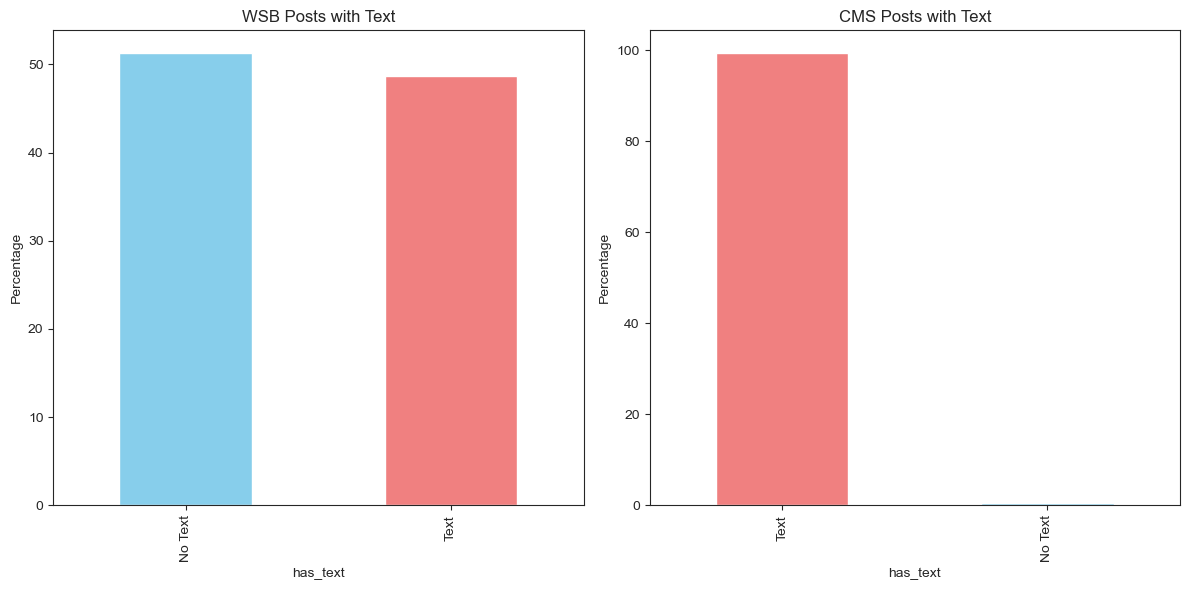

In [8]:
# Step 1: Create a new column to indicate whether the post has text or not
wsb_merged['has_text'] = wsb_merged['text'].notnull()  # Create a new column 'has_text' indicating if text is not null
cms_merged['has_text'] = cms_merged['text'].notnull()  # Create a new column 'has_text' indicating if text is not null

# Step 2: Calculate the percentage of posts with text
wsb_text_percentage = wsb_merged['has_text'].value_counts(normalize=True) * 100
cms_text_percentage = cms_merged['has_text'].value_counts(normalize=True) * 100

# Step 3: Plot the percentage using a bar plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
wsb_text_percentage.plot(kind='bar', ax=axes[0], color=['skyblue', 'lightcoral'])
axes[0].set_title('WSB Posts with Text')
axes[0].set_xticklabels(['No Text', 'Text'])
axes[0].set_ylabel('Percentage')

cms_text_percentage.plot(kind='bar', ax=axes[1], color=['lightcoral', 'skyblue'])
axes[1].set_title('CMS Posts with Text')
axes[1].set_xticklabels(['Text', 'No Text'])
axes[1].set_ylabel('Percentage')

plt.tight_layout()
plt.show()

In [9]:
# percentage without NaN text in wsb
wsb_text_percentage

has_text
False    51.292951
True     48.707049
Name: proportion, dtype: float64

In [10]:
# percentage without NaN text in cms
cms_text_percentage

has_text
True     99.375459
False     0.624541
Name: proportion, dtype: float64

One clear indication from this comparison shows that text is more prevalent in CryptoMoonShots than in wallstreetbets. This makes sense as a common post in wsb focuses on providing an image for gains or lossess on a trading platform like Robinhood. 

## Most common bi-grams and tri-grams from titles

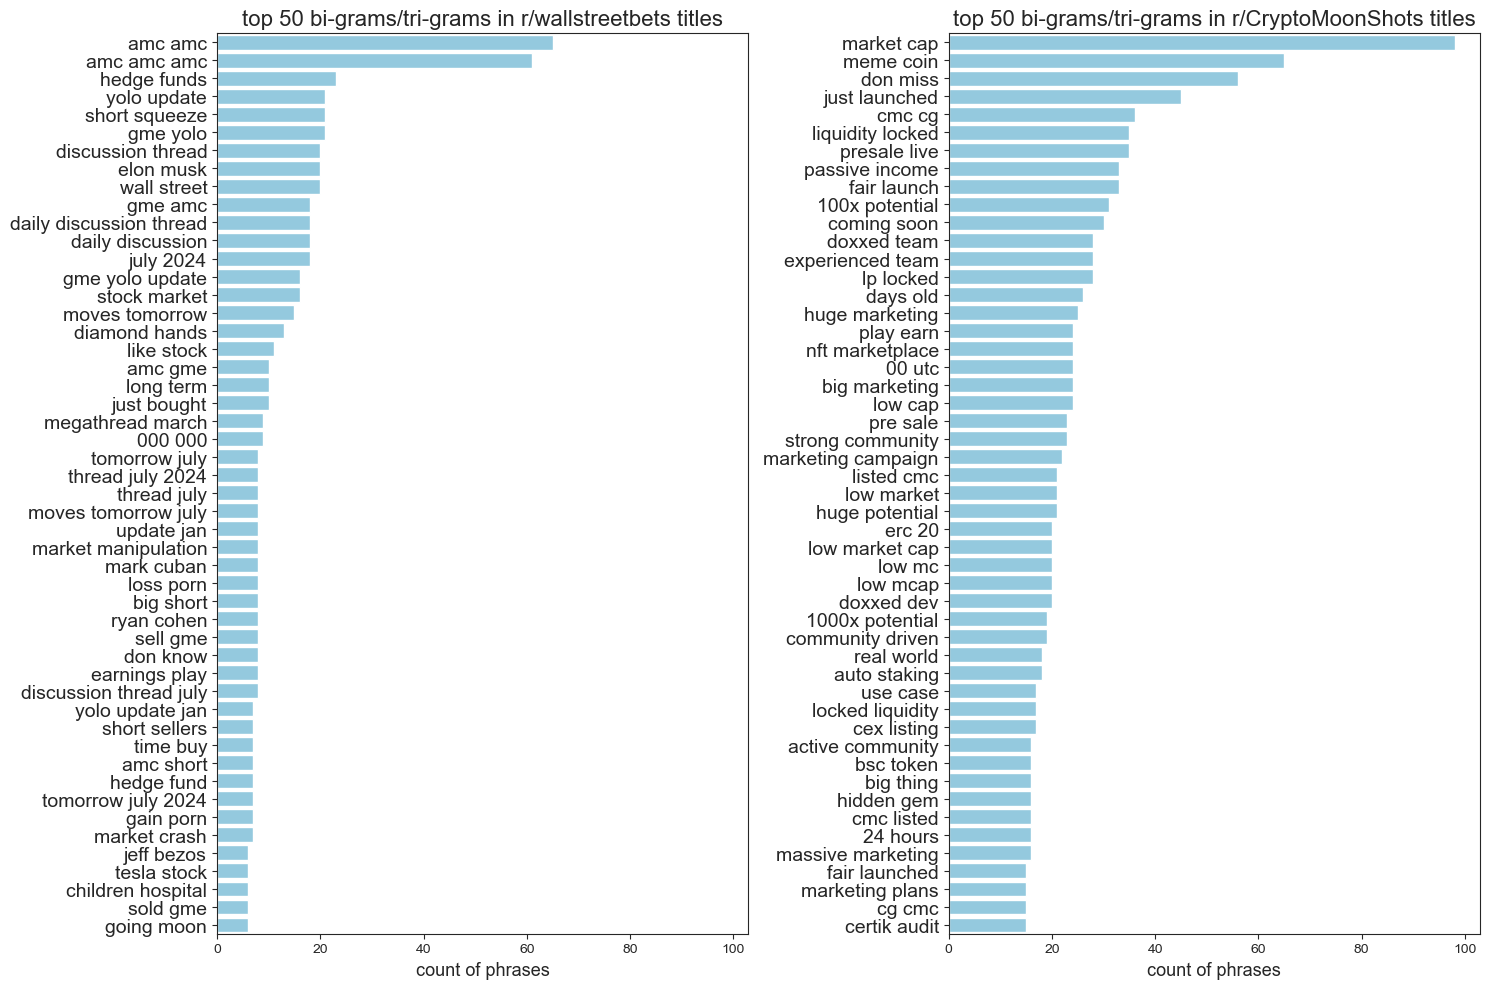

In [13]:
# instantiate a basic vectoriser with only settings for extracting bi- and tri-grams
cvec = CountVectorizer(stop_words='english', ngram_range=(2, 3))

# r/wallstreetbets - fit/transform count vectoriser to title and get the 50 phrases with the highest count
vec_wsb = cvec.fit_transform(wsb_merged['title'])
vec_wsb = pd.DataFrame(vec_wsb.toarray(), columns=cvec.get_feature_names_out())
wsb_title_50 = vec_wsb.sum().sort_values(ascending=False).head(50)

# r/CryptoMoonShots - fit/transform count vectoriser to title and get the 50 phrases with the highest count
vec_cms = cvec.fit_transform(cms_merged['title'])
vec_cms = pd.DataFrame(vec_cms.toarray(), columns=cvec.get_feature_names_out())
cms_title_50 = vec_cms.sum().sort_values(ascending=False).head(50)

# plot results
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 10), sharex=True)

sns.barplot(y=wsb_title_50.index.values, x=wsb_title_50, color='skyblue', ax=ax[0])
ax[0].set_title('top 50 bi-grams/tri-grams in r/wallstreetbets titles', fontsize=16)
ax[0].set_xlabel('count of phrases', fontsize=13)
plt.setp(ax[0].get_yticklabels(), fontsize=14)

sns.barplot(y=cms_title_50.index.values, x=cms_title_50, color='skyblue', ax=ax[1])
ax[1].set_title('top 50 bi-grams/tri-grams in r/CryptoMoonShots titles', fontsize=16)
ax[1].set_xlabel('count of phrases', fontsize=13)
plt.setp(ax[1].get_yticklabels(), fontsize=14)

plt.tight_layout()
plt.show()

Common Bi-grams/Tri-grams in Post's Text (content)

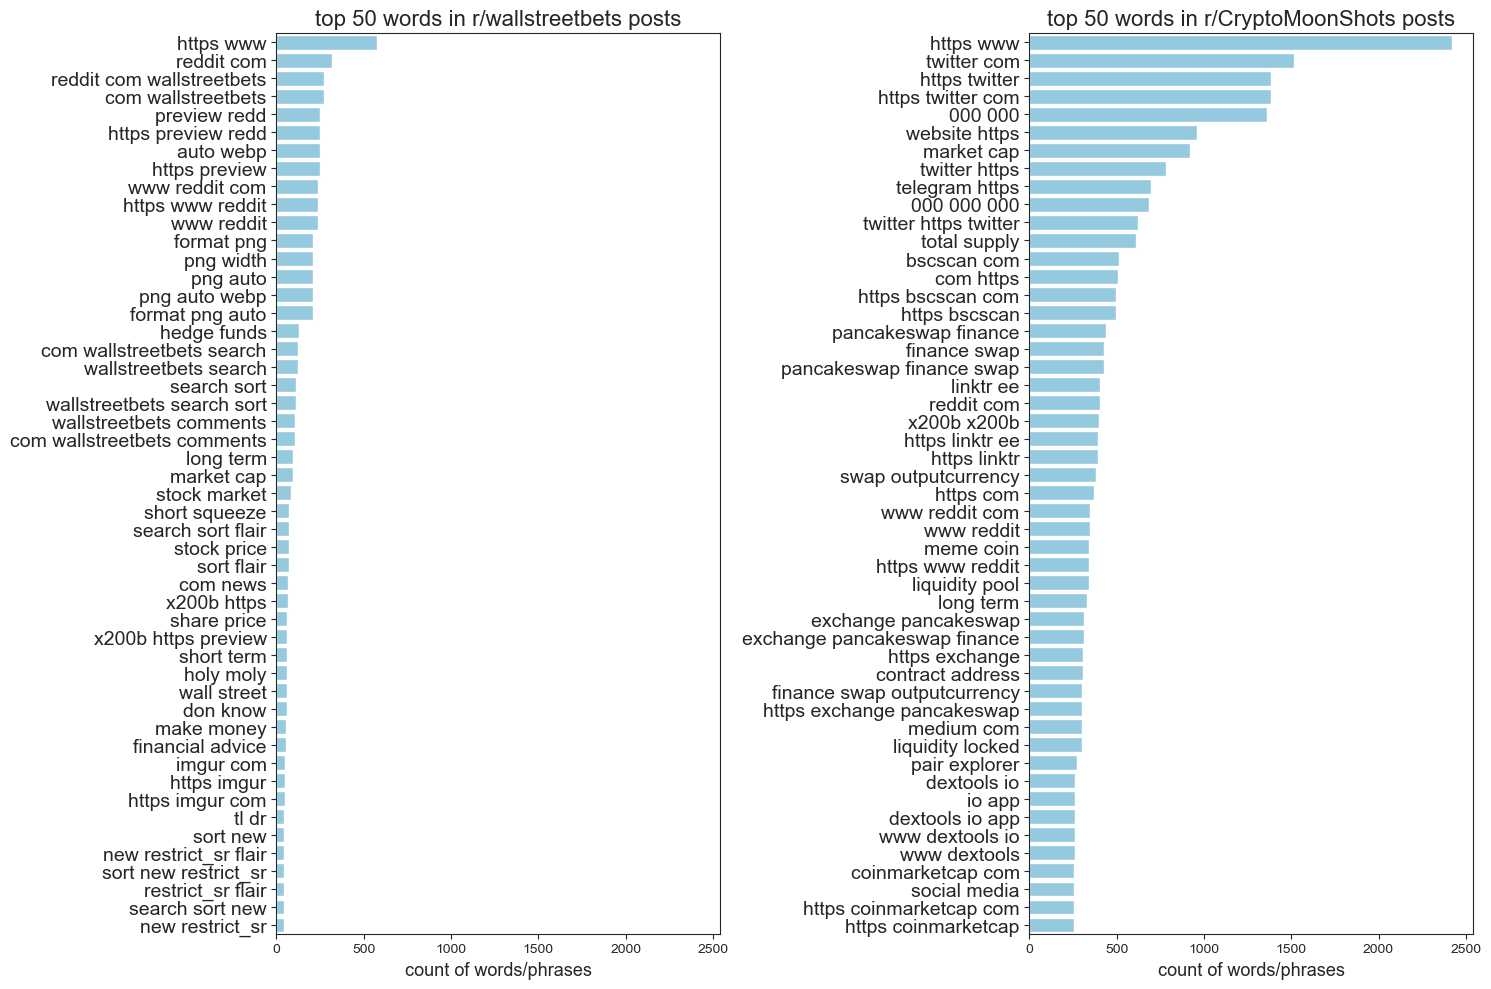

In [15]:
# preliminary filling of nan values for vectorising/plotting
wsb_merged['text'].fillna(value='notexthere', inplace=True)
cms_merged['text'].fillna(value='notexthere', inplace=True)

#  r/wallstreetbets - fit/transform count vectoriser to text and get the 50 phrases with the highest count
vec_wsb = cvec.fit_transform(wsb_merged['text'])
vec_wsb = pd.DataFrame(vec_wsb.toarray(), columns=cvec.get_feature_names_out())  # Use get_feature_names_out() instead of get_feature_names()
wsb_post_50 = vec_wsb.sum().sort_values(ascending=False).head(50)

# r/CryptoMoonShots - fit/transform count vectoriser to text and get the 50 phrases with the highest count
vec_cms = cvec.fit_transform(cms_merged['text'])
vec_cms = pd.DataFrame(vec_cms.toarray(), columns=cvec.get_feature_names_out())  # Use get_feature_names_out() instead of get_feature_names()
cms_post_50 = vec_cms.sum().sort_values(ascending=False).head(50)

# plot results
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 10), sharex=True)

sns.barplot(y=wsb_post_50.index.values, x=wsb_post_50, color='skyblue', ax=ax[0])
ax[0].set_title('top 50 words in r/wallstreetbets posts', fontsize=16)
ax[0].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[0].get_yticklabels(), fontsize=14)

sns.barplot(y=cms_post_50.index.values, x=cms_post_50, color='skyblue', ax=ax[1])
ax[1].set_title('top 50 words in r/CryptoMoonShots posts', fontsize=16)
ax[1].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[1].get_yticklabels(), fontsize=14)

plt.tight_layout()
plt.show()

Clearly we have a lot of use of words associated with links and some random combination of numbers. Let's try to preprocess this data and make it easier for our models in the next notebook. 

### Preprocessing

In [18]:
def preprocess(df):
    # Fill in null values
    df.fillna(value='notexthere', inplace=True)
    
    # Get text lengths
    df['title_len'] = [len(x) for x in df['title'].str.split(' ')]
    df['text_len'] = [len(x) for x in df['text'].str.split(' ')]

    # Remove links
    regex_html = r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)'
    df['title'].replace(regex=True, inplace=True, to_replace=regex_html, value=r'')
    df['text'].replace(regex=True, inplace=True, to_replace=regex_html, value=r'')

    return df

In [19]:
preprocess(wsb_merged)

,id,datetime,title,text,score,upvote_ratio,url,subreddit,has_text,title_len,text_len
0,1dzdf1j,2024-07-09 21:00:53,$Sofi is coming back .,I suggest you buy and hold .,3,0.71,https://i.redd.it/ffwh4k2u4kbd1.jpeg,wallstreetbets,True,5,7
1,1dzdebj,2024-07-09 21:00:11,What’s going on with BABA?,The stock has performed really poorly over the...,2,0.67,https://www.reddit.com/r/wallstreetbets/commen...,wallstreetbets,True,6,84
2,1dzd0u6,2024-07-09 20:44:37,ZI Yolo better late than early,DD was some guy posted about seeing a high vol...,2,0.75,https://i.redd.it/a2n775jx1kbd1.jpeg,wallstreetbets,True,7,14
3,1dzckvv,2024-07-09 20:26:14,We are already in a recession,notexthere,3,0.57,https://i.redd.it/1uao7vklyjbd1.png,wallstreetbets,False,6,1
4,1dzcjix,2024-07-09 20:24:41,🍔McDonalds🍔: At ATL in 52 weeks. How to make y...,"Hello gentleman. \n\nFirst of all, the only DD...",1,0.55,https://www.reddit.com/r/wallstreetbets/commen...,wallstreetbets,True,16,138
...,...,...,...,...,...,...,...,...,...,...,...
2818,5xtflv,2017-03-06 14:18:59,Oh $SNAP,Eat your shorts.\n\n$28.45 pre-market. Printin...,0,0.50,https://www.reddit.com/r/wallstreetbets/commen...,wallstreetbets,True,2,13
2819,5travk,2017-02-13 05:59:06,If this gets 1000 upvotes Im going to sell my ...,Just purchased all parts and built it in decem...,10,0.52,https://www.reddit.com/r/wallstreetbets/commen...,wallstreetbets,True,22,61
2820,5rb9c7,2017-01-31 21:49:30,Upvote to ban all of Canada from the internet,Pls\n\n\n\n\n\n\n\nWhen Canadian autism hits c...,37578,0.67,https://www.reddit.com/r/wallstreetbets/commen...,wallstreetbets,True,9,8
2821,5p08s8,2017-01-19 23:28:19,The official portrait of our Lord and Savior s...,notexthere,5,0.51,http://imgur.com/nxDkBYM,wallstreetbets,False,19,1


In [20]:
preprocess(cms_merged)

,id,datetime,title,text,score,upvote_ratio,url,subreddit,has_text,title_len,text_len
0,1dzdgyf,2024-07-09 21:03:03,$Lndry | Major Updates for coming up – Excitin...,Major Updates for LNDRY – Exciting Times Ahead...,55,1.00,https://www.reddit.com/r/CryptoMoonShots/comme...,CryptoMoonShots,True,18,172
1,1dzcnf8,2024-07-09 20:29:06,Nancy coin Daily Update!,"Update time!\n\nIt's day 4 for Nancy coin, and...",5,1.00,https://www.reddit.com/r/CryptoMoonShots/comme...,CryptoMoonShots,True,4,420
2,1dzb3et,2024-07-09 19:25:17,I know you're a JEET and so am I,How many of you have ever jeeted a coin? I'm n...,9,0.91,https://www.reddit.com/r/CryptoMoonShots/comme...,CryptoMoonShots,True,9,291
3,1dz7m7a,2024-07-09 17:03:20,$HEGE Secures Dual Exchange Listings on MEXC a...,I just got some electrifying news that I had t...,12,0.93,https://www.reddit.com/r/CryptoMoonShots/comme...,CryptoMoonShots,True,13,260
4,1dz7ibw,2024-07-09 16:59:18,$CEEZUR keep growing fast and looking really b...,$CEEZUR is the first of the ancient politifi t...,70,0.95,https://www.reddit.com/r/CryptoMoonShots/comme...,CryptoMoonShots,True,20,196
...,...,...,...,...,...,...,...,...,...,...,...
2717,81imud,2018-03-02 21:41:43,Whats the deal with this moon baby?,I still cant find anyone talking about it.\n\n...,0,0.50,https://www.reddit.com/r/CryptoMoonShots/comme...,CryptoMoonShots,True,7,198
2718,7vqu3h,2018-02-06 21:34:59,Aigang - Way Undervalued at its $9mil market c...,notexthere,5,0.57,https://medium.com/aigang-network/aigang-dev-u...,CryptoMoonShots,False,21,1
2719,7urukk,2018-02-02 15:01:36,ELTCOIN Is Only 3 Cents.. Could This Crypto Cu...,notexthere,0,0.50,http://blogforbitcoin.com/eltcoin-is-only-3-ce...,CryptoMoonShots,False,11,1
2720,7untqv,2018-02-02 01:33:52,"PACCoin, reborn. Read em and weep.",notexthere,6,0.63,http://download.paccoin.net/PAC_White_Paper_20...,CryptoMoonShots,False,6,1


In [21]:
wsb_merged.describe().T #transpose for easier reading

,count,mean,std,min,25%,50%,75%,max
score,2823.0,21318.732908,37077.916488,0.00,6.00,79.00,39420.50,486588.00
upvote_ratio,2823.0,0.745707,0.195797,0.18,0.53,0.83,0.92,0.99
title_len,2823.0,9.843429,7.849867,1.00,5.00,8.00,12.00,60.00
text_len,2823.0,92.084662,217.705105,1.00,1.00,1.00,93.50,4331.00


In [22]:
cms_merged.describe().T #transpose for easier reading

,count,mean,std,min,25%,50%,75%,max
score,2722.0,844.999265,1137.613227,0.00,2.0,49.00,1997.75,7540.0
upvote_ratio,2722.0,0.813104,0.207661,0.25,0.6,0.94,0.99,1.0
title_len,2722.0,16.179647,11.149994,1.00,8.0,13.00,22.00,60.0
text_len,2722.0,275.117561,177.210869,1.00,171.0,237.00,349.00,2324.0


EDA: Distribution Plots

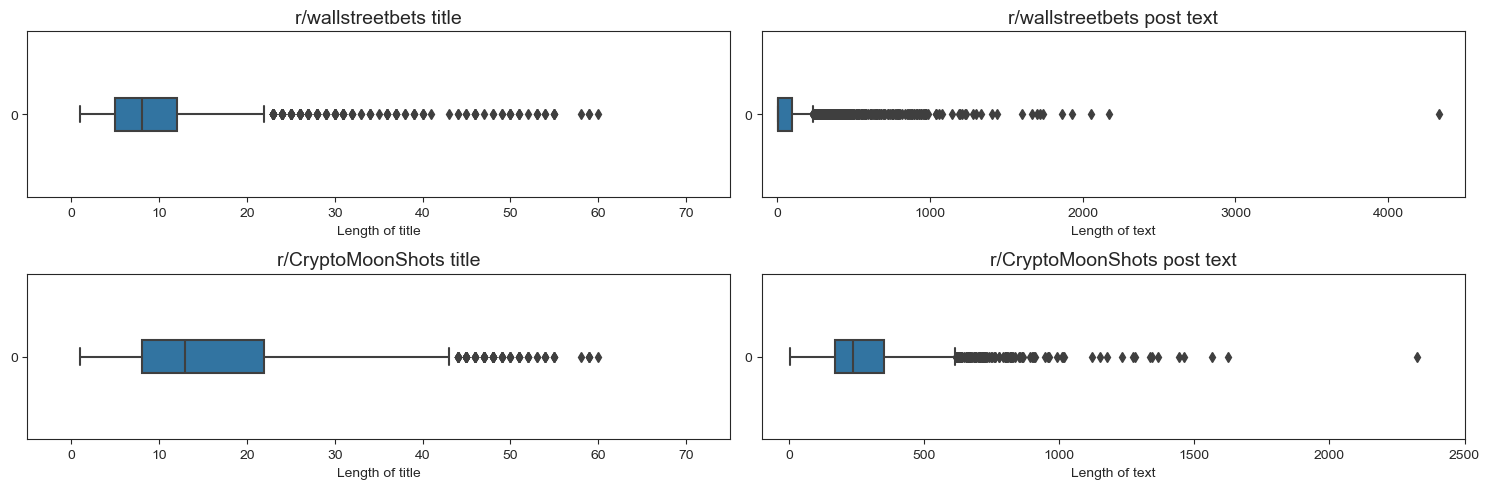

In [24]:
# plot distributions with same x axis range for each category
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 5))

sns.boxplot(wsb_merged['title_len'], ax = ax[0][0], width = 0.2, orient='h')
ax[0][0].set_xlabel('Length of title')
ax[0][0].set_xlim(-5,75)
ax[0][0].set_title('r/wallstreetbets title', fontsize=14)
sns.boxplot(wsb_merged['text_len'], ax = ax[0][1], width = 0.2,  orient='h')
ax[0][1].set_xlabel('Length of text')
ax[0][1].set_xlim(-100,4500)
ax[0][1].set_title('r/wallstreetbets post text', fontsize=14)

sns.boxplot(cms_merged['title_len'], ax = ax[1][0], width = 0.2, orient='h')
ax[1][0].set_xlabel('Length of title')
ax[1][0].set_xlim(-5,75)
ax[1][0].set_title('r/CryptoMoonShots title', fontsize=14)
sns.boxplot(cms_merged['text_len'], ax = ax[1][1], width = 0.2, orient='h')
ax[1][1].set_xlabel('Length of text')
ax[1][1].set_xlim(-100,2500)
ax[1][1].set_title('r/CryptoMoonShots post text', fontsize=14)

plt.tight_layout()

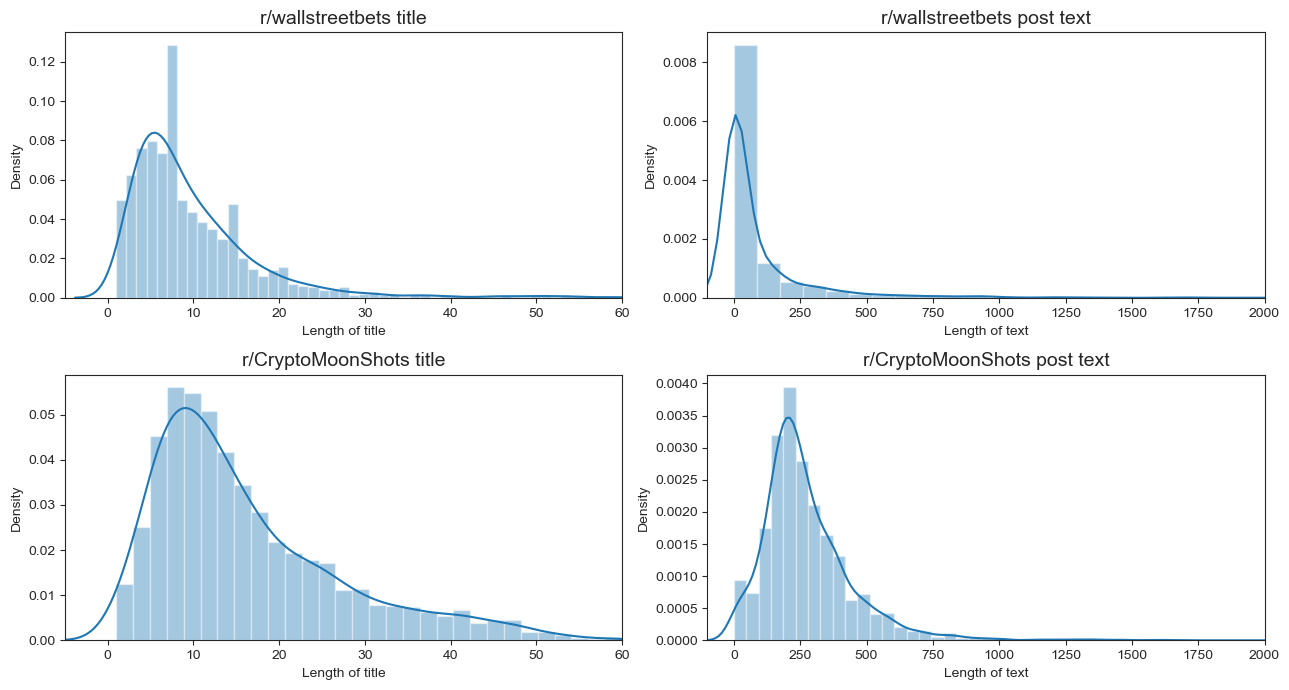

In [25]:
# plot distributions with same x axis range for each category
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (13, 7))

sns.distplot(wsb_merged['title_len'], ax = ax[0][0])
ax[0][0].set_xlabel('Length of title')
ax[0][0].set_xlim(-5,60)
ax[0][0].set_title('r/wallstreetbets title', fontsize=14)
sns.distplot(wsb_merged['text_len'], ax = ax[0][1])
ax[0][1].set_xlabel('Length of text')
ax[0][1].set_xlim(-100,2000)
ax[0][1].set_title('r/wallstreetbets post text', fontsize=14)

sns.distplot(cms_merged['title_len'], ax = ax[1][0])
ax[1][0].set_xlabel('Length of title')
ax[1][0].set_xlim(-5,60)
ax[1][0].set_title('r/CryptoMoonShots title', fontsize=14)
sns.distplot(cms_merged['text_len'], ax = ax[1][1])
ax[1][1].set_xlabel('Length of text')
ax[1][1].set_xlim(-100,2000)
ax[1][1].set_title('r/CryptoMoonShots post text', fontsize=14)


plt.tight_layout()

Check word ranking again after preprocessing

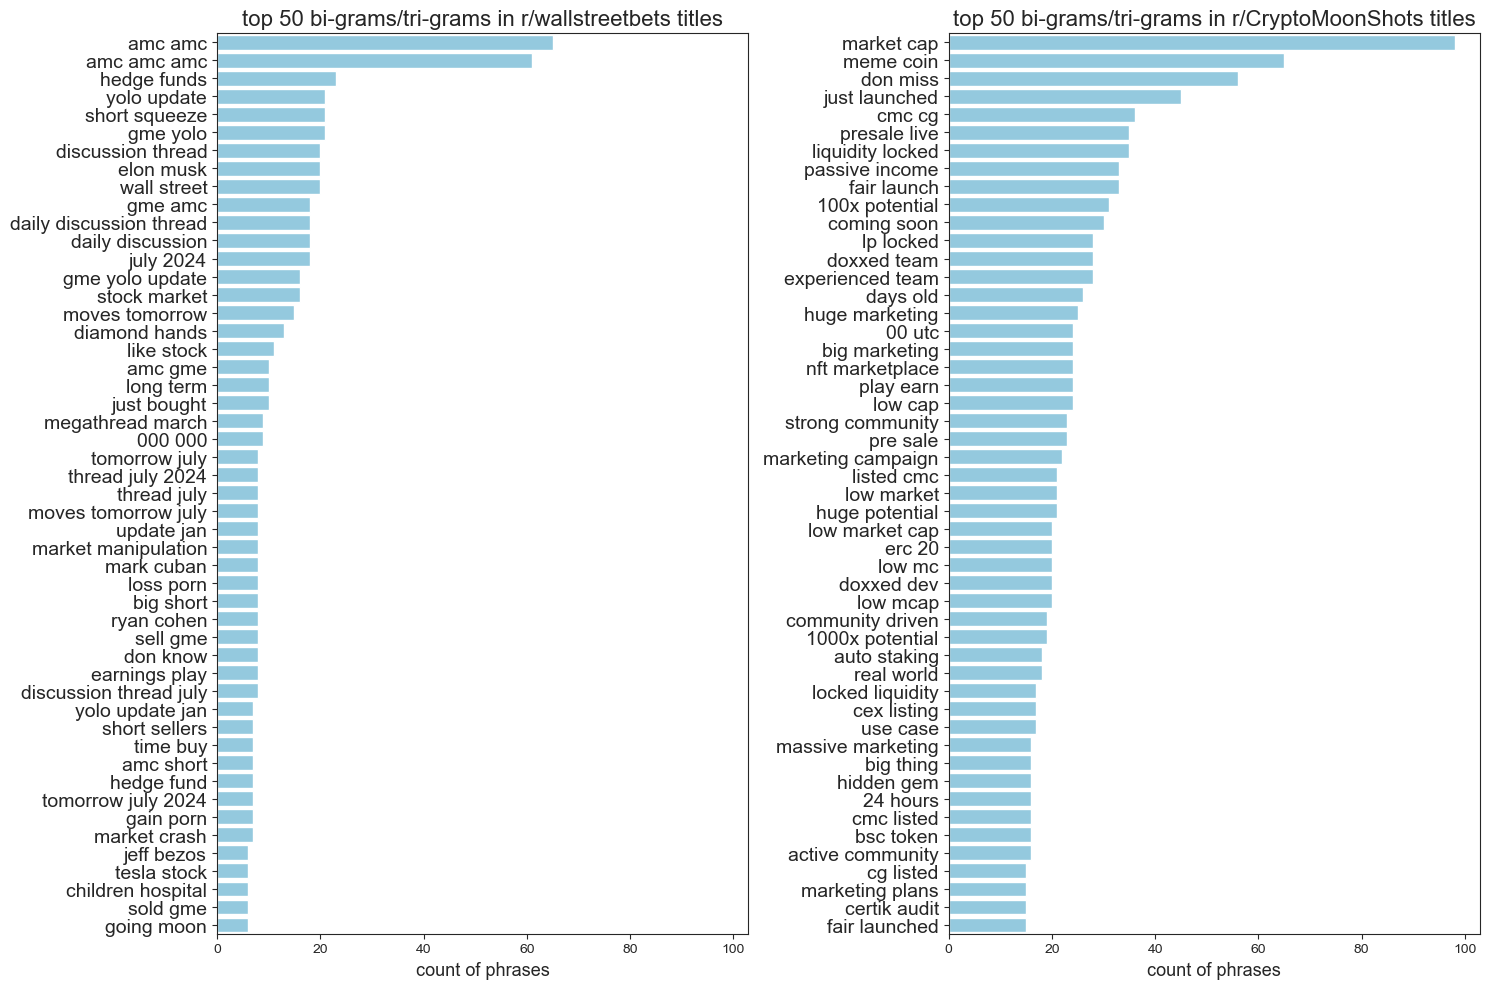

In [27]:
# instantiate a basic vectoriser with only settings for extracting bi- and tri-grams
cvec = CountVectorizer(stop_words='english', ngram_range=(2, 3))

# r/wallstreetbets - fit/transform count vectoriser to title and get the 50 phrases with the highest count
vec_wsb = cvec.fit_transform(wsb_merged['title'])
vec_wsb = pd.DataFrame(vec_wsb.toarray(), columns=cvec.get_feature_names_out())
wsb_title_50 = vec_wsb.sum().sort_values(ascending=False).head(50)

# r/CryptoMoonShots - fit/transform count vectoriser to title and get the 50 phrases with the highest count
vec_cms = cvec.fit_transform(cms_merged['title'])
vec_cms = pd.DataFrame(vec_cms.toarray(), columns=cvec.get_feature_names_out())
cms_title_50 = vec_cms.sum().sort_values(ascending=False).head(50)

# plot results
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 10), sharex=True)

sns.barplot(y=wsb_title_50.index.values, x=wsb_title_50, color='skyblue', ax=ax[0])
ax[0].set_title('top 50 bi-grams/tri-grams in r/wallstreetbets titles', fontsize=16)
ax[0].set_xlabel('count of phrases', fontsize=13)
plt.setp(ax[0].get_yticklabels(), fontsize=14)

sns.barplot(y=cms_title_50.index.values, x=cms_title_50, color='skyblue', ax=ax[1])
ax[1].set_title('top 50 bi-grams/tri-grams in r/CryptoMoonShots titles', fontsize=16)
ax[1].set_xlabel('count of phrases', fontsize=13)
plt.setp(ax[1].get_yticklabels(), fontsize=14)

plt.tight_layout()
plt.show()

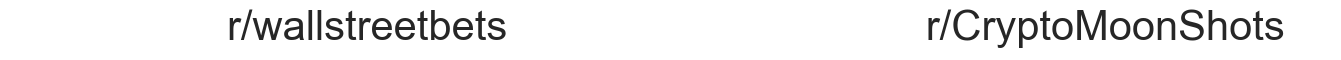

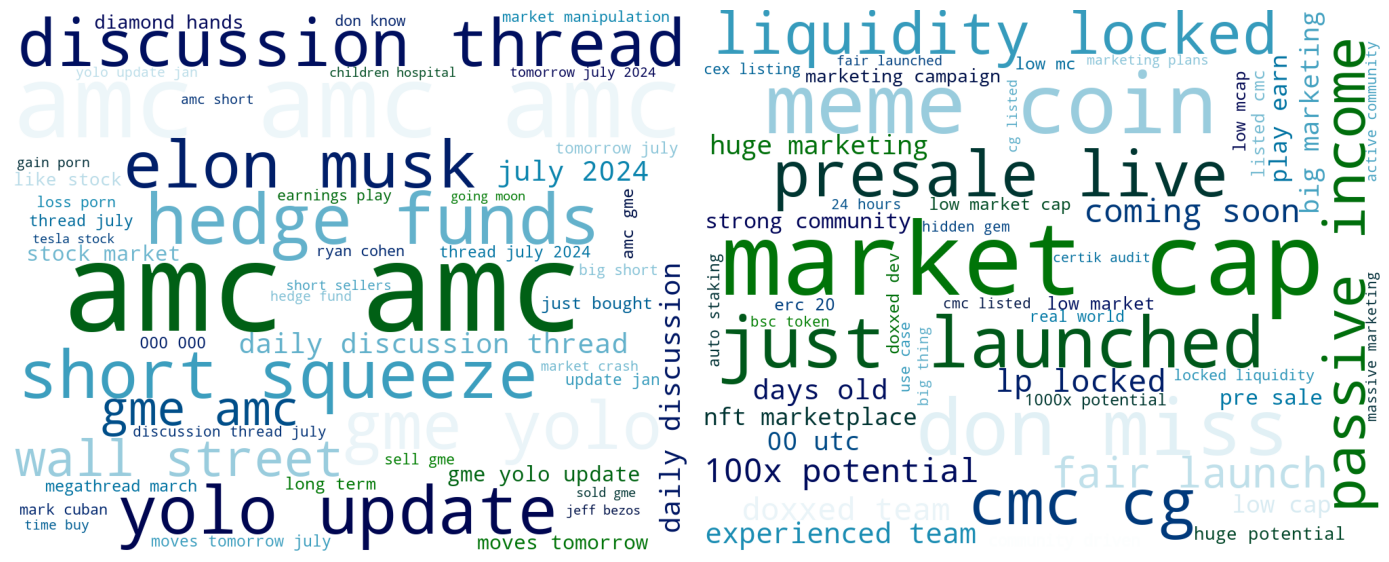

In [28]:
# set up WordCloud
wsb_cloud = WordCloud(max_words= 50, width = 1000, height = 800, background_color ='white',
                  colormap='ocean').generate_from_frequencies(wsb_title_50) 

cms_cloud = WordCloud(max_words= 50, width = 1000, height = 800, background_color ='white',
                  colormap='ocean').generate_from_frequencies(cms_title_50) 

plt.figure(figsize=(8, 0.3))
plt.text(x = 0.35,                              
         y = 0.9,                             
         s = 'r/wallstreetbets                                    r/CryptoMoonShots    ', 
         ha = 'left',                        
         va = 'center',                       
         size = 30)                         
plt.axis('off')

# plot the WordCloud image 
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 6))
ax[0].imshow(wsb_cloud)
ax[0].axis('off')
ax[1].imshow(cms_cloud)
ax[1].axis('off')
plt.tight_layout()

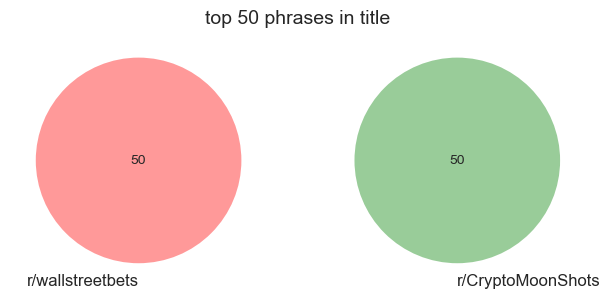

In [29]:
venn2([set(wsb_title_50.index), set(cms_title_50.index)], set_labels = ('r/wallstreetbets','r/CryptoMoonShots'))
plt.title('top 50 phrases in title', fontsize=14)
plt.tight_layout()

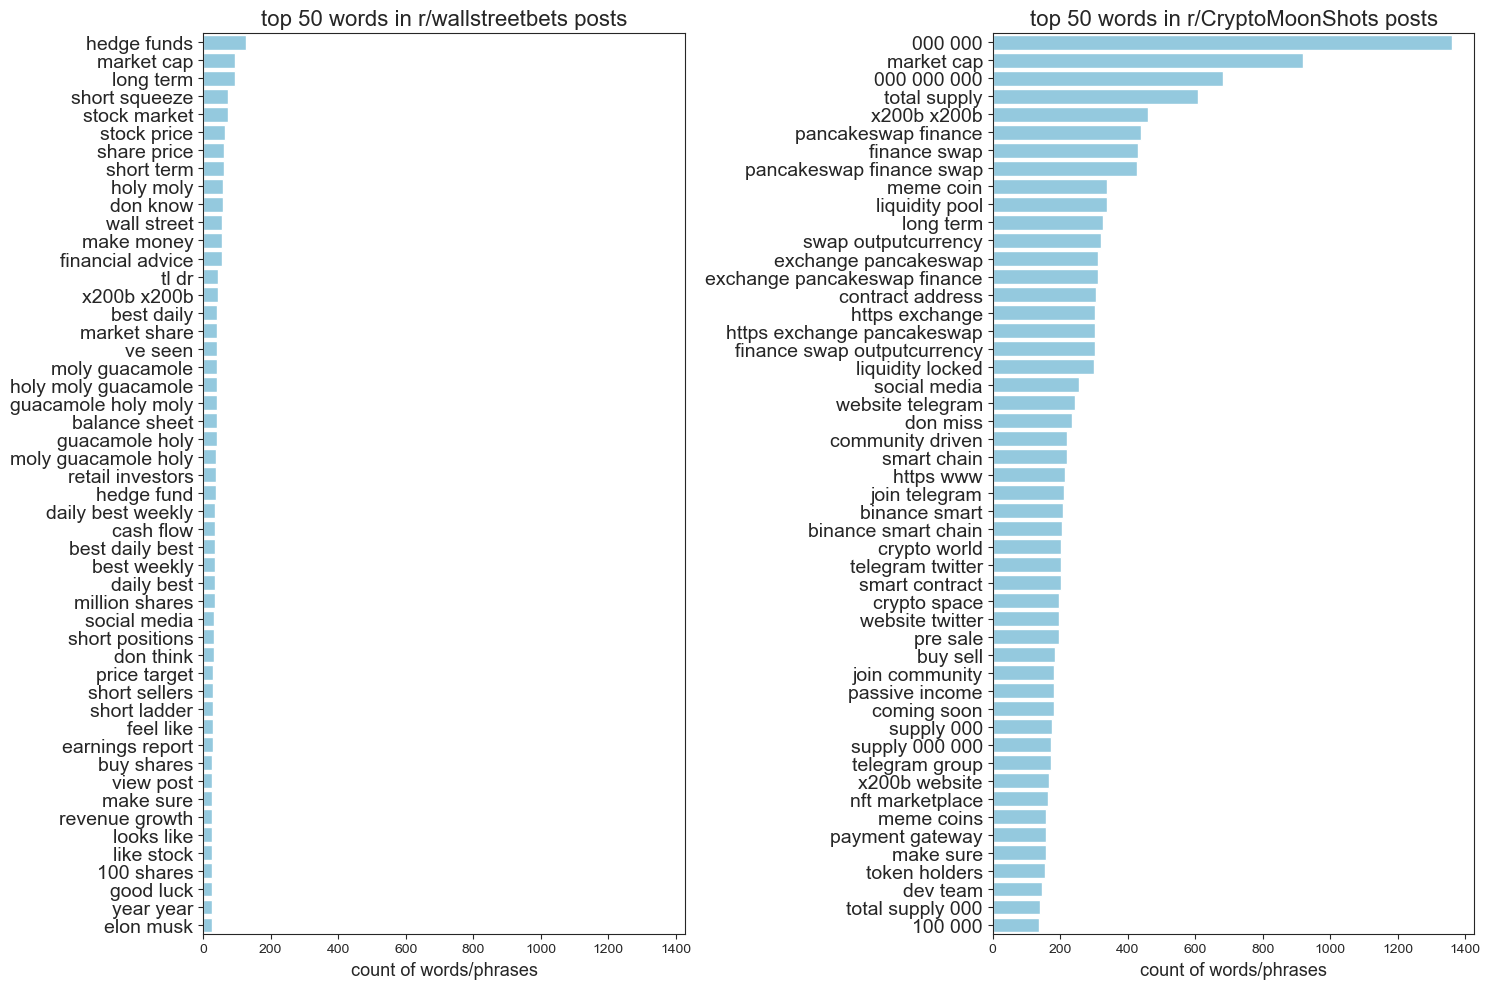

In [30]:
# preliminary filling of nan values for vectorising/plotting
wsb_merged['text'].fillna(value='notexthere', inplace=True)
cms_merged['text'].fillna(value='notexthere', inplace=True)

#  r/wallstreetbets - fit/transform count vectoriser to text and get the 50 phrases with the highest count
vec_wsb = cvec.fit_transform(wsb_merged['text'])
vec_wsb = pd.DataFrame(vec_wsb.toarray(), columns=cvec.get_feature_names_out())  # Use get_feature_names_out() instead of get_feature_names()
wsb_post_50 = vec_wsb.sum().sort_values(ascending=False).head(50)

# r/CryptoMoonShots - fit/transform count vectoriser to text and get the 50 phrases with the highest count
vec_cms = cvec.fit_transform(cms_merged['text'])
vec_cms = pd.DataFrame(vec_cms.toarray(), columns=cvec.get_feature_names_out())  # Use get_feature_names_out() instead of get_feature_names()
cms_post_50 = vec_cms.sum().sort_values(ascending=False).head(50)

# plot results
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 10), sharex=True)

sns.barplot(y=wsb_post_50.index.values, x=wsb_post_50, color='skyblue', ax=ax[0])
ax[0].set_title('top 50 words in r/wallstreetbets posts', fontsize=16)
ax[0].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[0].get_yticklabels(), fontsize=14)

sns.barplot(y=cms_post_50.index.values, x=cms_post_50, color='skyblue', ax=ax[1])
ax[1].set_title('top 50 words in r/CryptoMoonShots posts', fontsize=16)
ax[1].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[1].get_yticklabels(), fontsize=14)

plt.tight_layout()
plt.show()

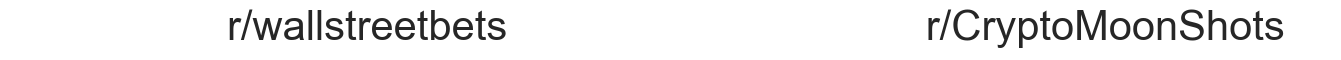

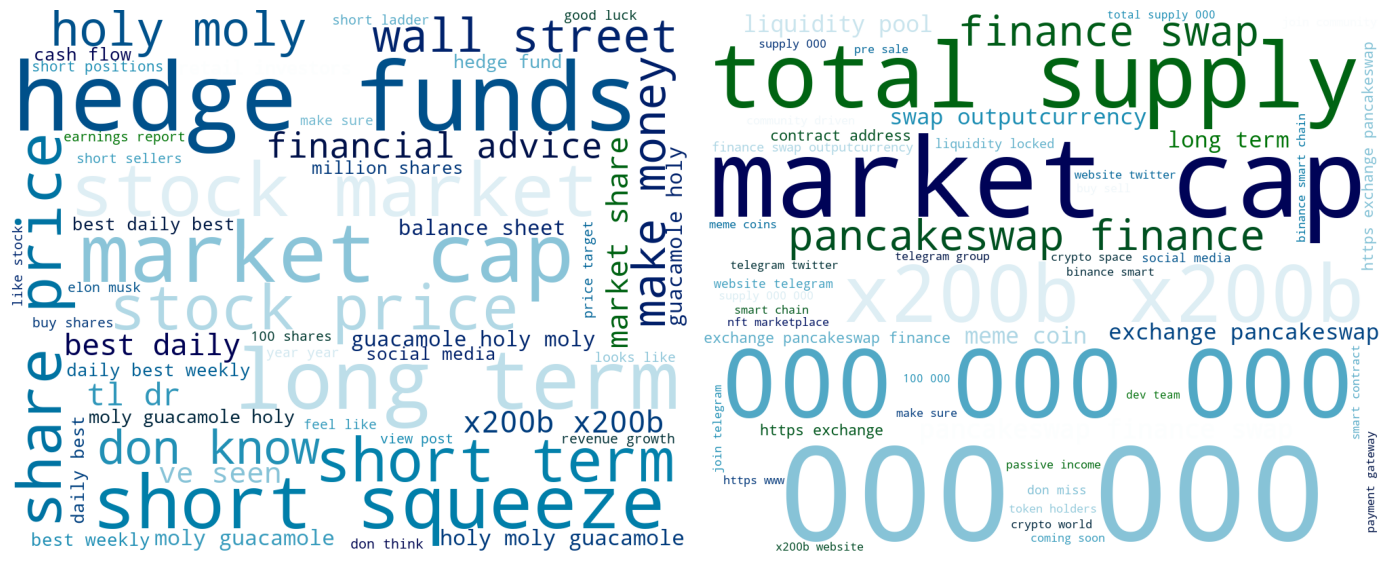

In [31]:
# set up WordCloud
wsb_cloud = WordCloud(max_words= 50, width = 1000, height = 800, background_color ='white',
                  colormap='ocean').generate_from_frequencies(wsb_post_50) 

cms_cloud = WordCloud(max_words= 50, width = 1000, height = 800, background_color ='white',
                  colormap='ocean').generate_from_frequencies(cms_post_50) 

plt.figure(figsize=(8, 0.3))
plt.text(x = 0.35,                              
         y = 0.9,                             
         s = 'r/wallstreetbets                                    r/CryptoMoonShots    ', 
         ha = 'left',                        
         va = 'center',                       
         size = 30)                         
plt.axis('off')

# plot the WordCloud image 
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 6))
ax[0].imshow(wsb_cloud)
ax[0].axis('off')
ax[1].imshow(cms_cloud)
ax[1].axis('off')
plt.tight_layout()

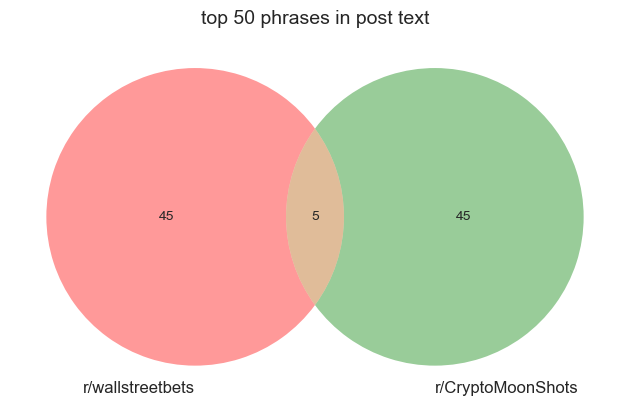

In [32]:
venn2([set(wsb_post_50.index), set(cms_post_50.index)], set_labels = ('r/wallstreetbets','r/CryptoMoonShots'))
plt.title('top 50 phrases in post text', fontsize=14)
plt.tight_layout()

Conclusions from EDA

**Focus on titles for prediction**: Titles are more informative than text of the posts, possibly because many posts in     r/wallstreetbets lack text. In addition, it seems text in r/CryptoMoonShots is full of numbers for wallet addresses and links for different crypto projects. 

Titles are likely stronger predictors of the respective subreddit category. In the next notebook, we'll use 'title' feature to explore model performance and compare metrics for future evaluation.

Merging into One DataFrame

In [36]:
# create dummy column for subreddits - 1 for r/wallstreetbets and 0 for r/CryptoMoonShots
wsb_merged['subreddit'] = 1
cms_merged['subreddit'] = 0

In [37]:
wsb_merged

,id,datetime,title,text,score,upvote_ratio,url,subreddit,has_text,title_len,text_len
0,1dzdf1j,2024-07-09 21:00:53,$Sofi is coming back .,I suggest you buy and hold .,3,0.71,https://i.redd.it/ffwh4k2u4kbd1.jpeg,1,True,5,7
1,1dzdebj,2024-07-09 21:00:11,What’s going on with BABA?,The stock has performed really poorly over the...,2,0.67,https://www.reddit.com/r/wallstreetbets/commen...,1,True,6,84
2,1dzd0u6,2024-07-09 20:44:37,ZI Yolo better late than early,DD was some guy posted about seeing a high vol...,2,0.75,https://i.redd.it/a2n775jx1kbd1.jpeg,1,True,7,14
3,1dzckvv,2024-07-09 20:26:14,We are already in a recession,notexthere,3,0.57,https://i.redd.it/1uao7vklyjbd1.png,1,False,6,1
4,1dzcjix,2024-07-09 20:24:41,🍔McDonalds🍔: At ATL in 52 weeks. How to make y...,"Hello gentleman. \n\nFirst of all, the only DD...",1,0.55,https://www.reddit.com/r/wallstreetbets/commen...,1,True,16,138
...,...,...,...,...,...,...,...,...,...,...,...
2818,5xtflv,2017-03-06 14:18:59,Oh $SNAP,Eat your shorts.\n\n$28.45 pre-market. Printin...,0,0.50,https://www.reddit.com/r/wallstreetbets/commen...,1,True,2,13
2819,5travk,2017-02-13 05:59:06,If this gets 1000 upvotes Im going to sell my ...,Just purchased all parts and built it in decem...,10,0.52,https://www.reddit.com/r/wallstreetbets/commen...,1,True,22,61
2820,5rb9c7,2017-01-31 21:49:30,Upvote to ban all of Canada from the internet,Pls\n\n\n\n\n\n\n\nWhen Canadian autism hits c...,37578,0.67,https://www.reddit.com/r/wallstreetbets/commen...,1,True,9,8
2821,5p08s8,2017-01-19 23:28:19,The official portrait of our Lord and Savior s...,notexthere,5,0.51,http://imgur.com/nxDkBYM,1,False,19,1


In [38]:
# combine dataframes using concat
combined_df = pd.concat([wsb_merged, cms_merged], ignore_index=True)

In [39]:
combined_df.sample(25)

,id,datetime,title,text,score,upvote_ratio,url,subreddit,has_text,title_len,text_len
3275,1djppxz,2024-06-19 18:04:58,POWSCHE LIVE now on Twitter Spaces - JOIN NOW,**Date: WEDNESDAY 19th JUNE**\n\n[](\n\n**Time...,1,0.60,https://www.reddit.com/r/CryptoMoonShots/comme...,0,True,9,145
4583,om9av5,2021-07-17 18:01:24,$Ganymede (ETH/Uniswap)- Fair Launch 8 pm UTC ...,The 2nd token of the Moonconomy series by FLC ...,3997,0.98,https://www.reddit.com/r/CryptoMoonShots/comme...,0,True,19,218
2277,lags8u,2021-02-01 22:56:38,It needs to be said louder and more often. WE ...,"I know everyone is a bit shaken by today, and ...",45682,0.97,https://www.reddit.com/r/wallstreetbets/commen...,1,True,13,177
2647,l6432s,2021-01-27 13:06:10,AMC or GME?,I have $6000 CAD to put in. What's the buy?,0,0.47,https://www.reddit.com/r/wallstreetbets/commen...,1,True,3,10
1683,o15732,2021-06-16 13:43:14,It’s time to buy the VIX,🌈🐻 reporting for duty…\n\nVolatility is the on...,1,0.51,https://www.reddit.com/r/wallstreetbets/commen...,1,True,6,350
4903,mkm7zz,2021-04-05 14:39:58,$OBAMA is having a reversal!!!!,I made a post about $OBAMA and it went up 1000...,0,0.42,https://www.reddit.com/r/CryptoMoonShots/comme...,0,True,5,241
2480,l7feld,2021-01-29 01:35:58,IT'S POWER TO THE TRADERS NOW,notexthere,216086,0.97,https://v.redd.it/lu8aekujd6e61,1,False,6,1
3052,1drj19v,2024-06-29 19:32:37,Shackleford Finance Token (SHACK): The AI-Gene...,Hey MoonShooters!\n\nWe’re thrilled to introdu...,1,1.00,https://www.reddit.com/r/CryptoMoonShots/comme...,0,True,8,161
1134,10l98o3,2023-01-25 20:46:59,Pelosi strikes again,notexthere,47161,0.85,https://www.reddit.com/gallery/10l98o3,1,False,3,1
3393,1dfuvyg,2024-06-14 16:25:36,$CEEZUR | Experienced devs involved in project...,$CEEZUR is a memecoin that has everything to c...,357,1.00,https://www.reddit.com/r/CryptoMoonShots/comme...,0,True,13,310


In [40]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5545 entries, 0 to 5544
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            5545 non-null   object 
 1   datetime      5545 non-null   object 
 2   title         5545 non-null   object 
 3   text          5545 non-null   object 
 4   score         5545 non-null   int64  
 5   upvote_ratio  5545 non-null   float64
 6   url           5545 non-null   object 
 7   subreddit     5545 non-null   int64  
 8   has_text      5545 non-null   bool   
 9   title_len     5545 non-null   int64  
 10  text_len      5545 non-null   int64  
dtypes: bool(1), float64(1), int64(4), object(5)
memory usage: 438.7+ KB


In [41]:
# save combined DataFrame to a new csv file
combined_df.to_csv('data/combined_df.csv', index=False)